## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Import Packages

In [1]:
## Basic lib 
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

## Step 1 : Calibration 

In [2]:
#################################################################
# Step 1 : Calculate camera distortion coefficients
#################################################################
def getCameraCalibrationCoefficients(chessboardname, nx, ny):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny * nx, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    images = glob.glob(chessboardname)
    if len(images) > 0:
        print("images num for calibration : ", len(images))
    else:
        print("No image for calibration.")
        return
    
    ret_count = 0
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_size = (img.shape[1], img.shape[0])
        # Finde the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, add object points, image points
        if ret == True:
            ret_count += 1
            objpoints.append(objp)
            imgpoints.append(corners)
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    print('Do calibration successfully')
    return ret, mtx, dist, rvecs, tvecs

### Do calibration

In [3]:
nx = 9 
ny = 6
ret, mtx, dist, rvecs, tvecs = getCameraCalibrationCoefficients('camera_cal/calibration*.jpg', nx, ny)

images num for calibration :  20
Do calibration successfully


## Step 2 : Undistort Image

In [4]:
#################################################################
# Step 2 : Undistort image
#################################################################
def undistortImage(distortImage, mtx, dist):
    return cv2.undistort(distortImage, mtx, dist, None, mtx)

### Do undistortion

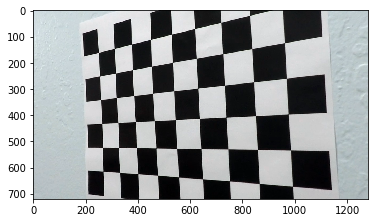

In [5]:
# Read distorted chessboard image
test_distort_image = cv2.imread('./camera_cal/calibration4.jpg')

# Do undistortion & display
test_undistort_image = undistortImage(test_distort_image, mtx, dist)
plt.figure()
plt.imshow(test_undistort_image)

## Step 3 : Warp Image

In [6]:
#################################################################
# Step 3 : Warp image based on src_points and dst_points
#################################################################
# The type of src_points & dst_points should be like
# np.float32([ [0,0], [100,200], [200, 300], [300,400]])
def warpImage(image, src_points, dst_points):
    image_size = (image.shape[1], image.shape[0])
    # rows = img.shape[0] 720
    # cols = img.shape[1] 1280
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped_image = cv2.warpPerspective(image, M,image_size, flags=cv2.INTER_LINEAR)
    
    return warped_image, M, Minv

### warp image

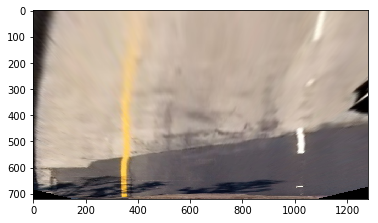

In [7]:
test_distort_image = cv2.imread('test_images/test4.jpg')

# Do undistortion & display
test_undistort_image = undistortImage(test_distort_image, mtx, dist)

src = np.float32([[580, 460], [700, 460], [1096, 720], [200, 720]])
dst = np.float32([[300, 0], [950, 0], [950, test_undistort_image.shape[0]], [300, test_undistort_image.shape[0]]])
test_warp_image, M, Minv = warpImage(test_undistort_image, src, dst)

plt.figure()
plt.imshow(cv2.cvtColor(test_warp_image, cv2.COLOR_BGR2RGB))

## Step 4 : Create Binary Image

In [8]:
#################################################################
# Step 4 : Create a thresholded binary image
#################################################################
def hlsLSelect(img, thresh=(220, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    l_channel = hls[:,:,1]
    l_channel = l_channel*(255/np.max(l_channel))
    binary_output = np.zeros_like(l_channel)
    binary_output[(l_channel > thresh[0]) & (l_channel <= thresh[1])] = 1
    return binary_output

def hlsSSelect(img, thresh=(125, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    s_channel = s_channel*(255/np.max(s_channel))
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def dirThreshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction_sobelxy = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(direction_sobelxy)
    binary_output[(direction_sobelxy >= thresh[0]) & (direction_sobelxy <= thresh[1])] = 1
    # 6) Return the binary image
    return binary_output

def magThreshold(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel)
    # 3) Calculate the magnitude 
    #abs_sobelx = np.absolute(sobelx)
    #abs_sobely = np.absolute(sobely)
    abs_sobelxy = np.sqrt(sobelx * sobelx + sobely * sobely)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobelxy = np.uint8(abs_sobelxy/np.max(abs_sobelxy) * 255)
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobelxy)
    binary_output[(scaled_sobelxy >= mag_thresh[0]) & (scaled_sobelxy <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def absSobelThreshold(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

def labBSelect(img, thresh=(215, 255)):
    # 1) Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    lab_b = lab[:,:,2]
    # don't normalize if there are no yellows in the image
    if np.max(lab_b) > 100:
        lab_b = lab_b*(255/np.max(lab_b))
    # 2) Apply a threshold to the L channel
    binary_output = np.ones_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 0
    # 3) Return a binary image of threshold result
    return binary_output

### create binary image

Text(0.5, 1.0, 'Sobel Absolute')

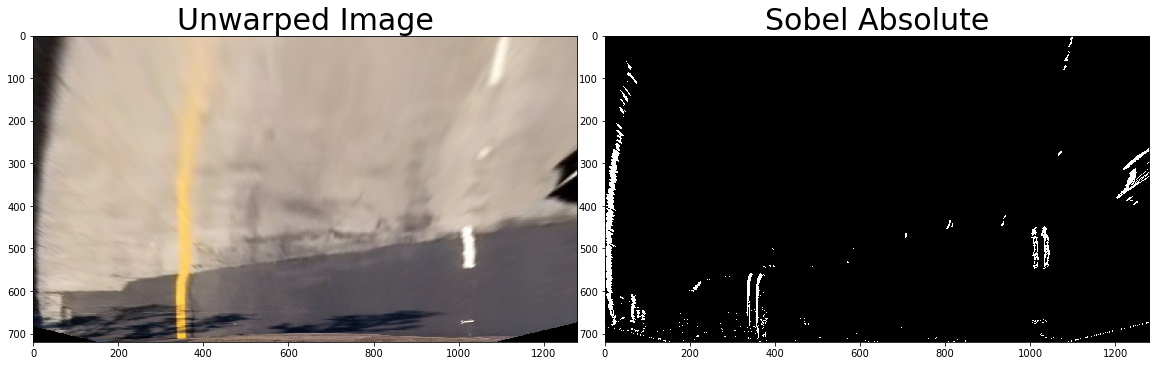

In [9]:
min_thresh = 30
max_thresh = 100
Result_sobelAbs = absSobelThreshold(test_warp_image, 'x', min_thresh, max_thresh)
# Visualize sobel absolute threshold
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(cv2.cvtColor(test_warp_image, cv2.COLOR_BGR2RGB))
ax1.set_title('Unwarped Image', fontsize=30)
ax2.imshow(Result_sobelAbs, cmap='gray')
ax2.set_title('Sobel Absolute', fontsize=30)

Text(0.5, 1.0, 'S Channel')

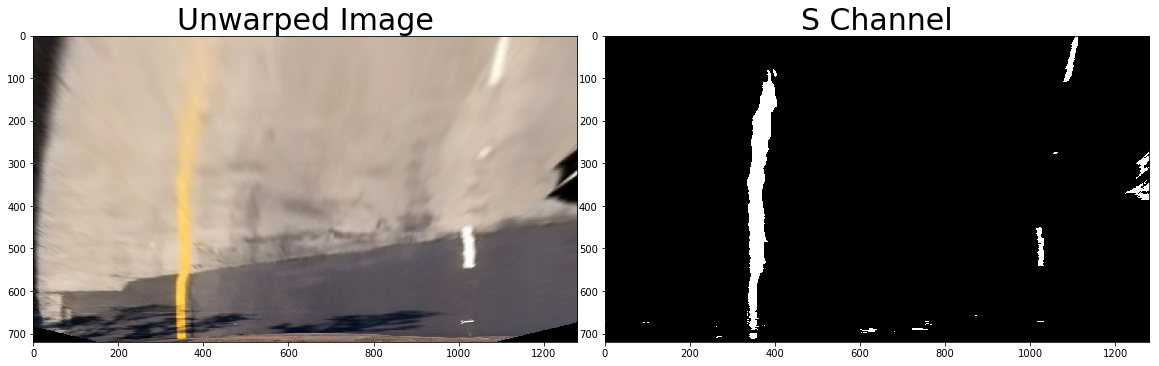

In [10]:
min_thresh = 150
max_thresh = 255
Result_hlsS = hlsSSelect(test_warp_image, (min_thresh, max_thresh))
# Visualize sobel absolute threshold
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(cv2.cvtColor(test_warp_image, cv2.COLOR_BGR2RGB))
ax1.set_title('Unwarped Image', fontsize=30)
ax2.imshow(Result_hlsS, cmap='gray')
ax2.set_title('S Channel', fontsize=30)

Text(0.5, 1.0, 'L Channel')

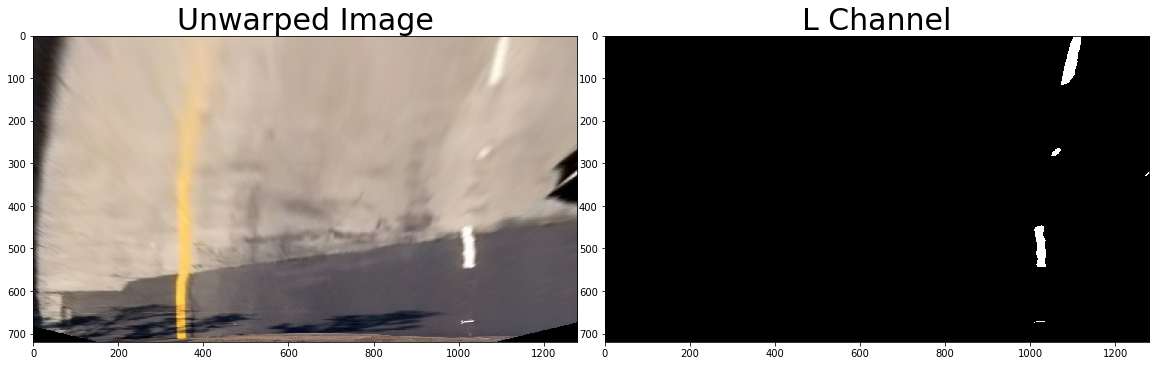

In [11]:
min_thresh = 215
max_thresh = 255
Result_hlsL = hlsLSelect(test_warp_image, (min_thresh, max_thresh))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(cv2.cvtColor(test_warp_image, cv2.COLOR_BGR2RGB))
ax1.set_title('Unwarped Image', fontsize=30)
ax2.imshow(Result_hlsL, cmap='gray')
ax2.set_title('L Channel', fontsize=30)

Text(0.5, 1.0, 'B Channel')

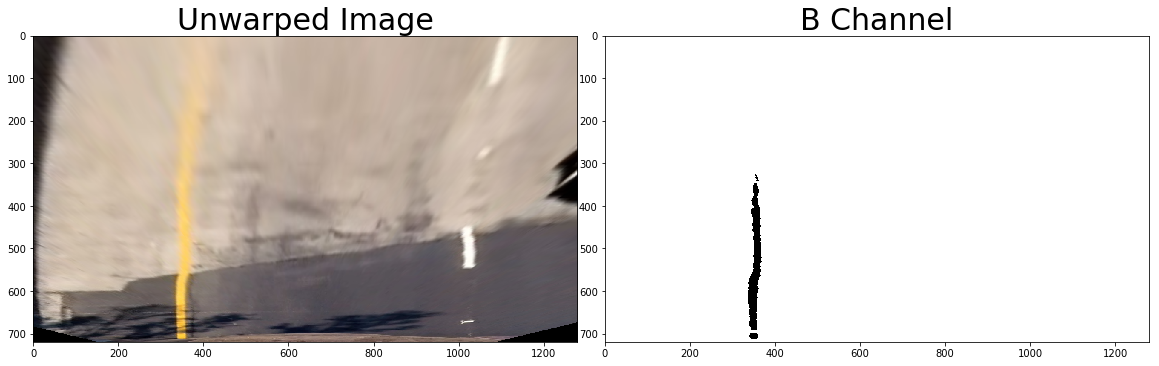

In [12]:
min_thresh = 215
max_thresh = 255
Result_labB = labBSelect(test_warp_image, (min_thresh, max_thresh))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(cv2.cvtColor(test_warp_image, cv2.COLOR_BGR2RGB))
ax1.set_title('Unwarped Image', fontsize=30)
ax2.imshow(Result_labB, cmap='gray')
ax2.set_title('B Channel', fontsize=30)

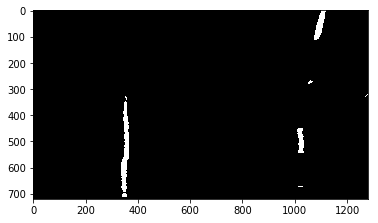

In [13]:
sx_binary  = absSobelThreshold(test_warp_image, 'x', 40, 100)
hlsL_binary = hlsLSelect(test_warp_image)
labB_binary = labBSelect(test_warp_image)
combined_binary = np.zeros_like(sx_binary)
combined_binary[(hlsL_binary == 1) | (labB_binary == 0)] = 1
plt.figure()
plt.imshow(combined_binary, cmap='gray')

## Step 5 : Detection

In [14]:
#################################################################
# Step 5 : Detect lane lines through moving window
#################################################################
def find_lane_pixels(binary_warped, nwindows, margin, minpix):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped, nwindows=9, margin=100, minpix=50):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(
        binary_warped, nwindows, margin, minpix)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit, ploty

### Do detection

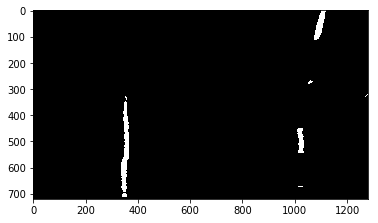

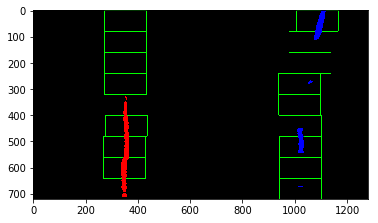

In [15]:
out_img, left_fit, right_fit, ploty = fit_polynomial(combined_binary, nwindows=9, margin=80, minpix=40)
plt.figure()
plt.imshow(combined_binary, cmap='gray')

plt.figure()
plt.imshow(out_img)

## Step 5 : Tracking

In [16]:
#################################################################
# Step 6 : Track lane lines based latest lane line result
#################################################################
def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit

def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 60

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty, left_fit, right_fit = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result, left_fit, right_fit, ploty

### Do tracking

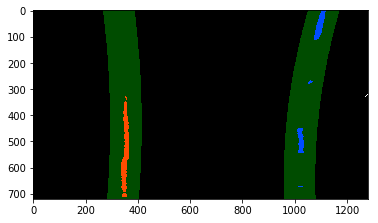

In [17]:
track_result, track_left_fit, track_right_fit, ploty,  = search_around_poly(combined_binary, left_fit, right_fit)
plt.figure()
plt.imshow(track_result)

## Measure Curvature and Offset

In [18]:
#################################################################
# Step 7 : Measure real world curvature
#################################################################
def measure_curvature_real(
    left_fit_cr, right_fit_cr, ploty,
    ym_per_pix = 30/720, xm_per_pix = 3.7/700):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    left_position = left_fit_cr[0]*720 + left_fit_cr[1]*720 + left_fit_cr[2]
    right_position = right_fit_cr[0]*720 + right_fit_cr[1]*720 + right_fit_cr[2]
    midpoint = 1280/2
    lane_center =(left_position + right_position)/2
    offset = (midpoint - lane_center) * xm_per_pix
    
    return left_curverad, right_curverad, offset

### Measure Curvature and Offset

In [19]:
left_curverad, right_curverad, offset = measure_curvature_real(track_left_fit, track_right_fit, ploty)
average_curverad = (left_curverad + right_curverad)/2
print(left_curverad, 'm', right_curverad, 'm', average_curverad, 'm')
print('offset : ', offset, 'm')

3545.456773303918 m 2490.082125781735 m 3017.769449542827 m
offset :  -0.10916721939592659 m


## Drawing

In [39]:
#################################################################
# Step 8 : Draw lane line result on undistorted image
#################################################################
def drawing(undist, bin_warped, color_warp, left_fitx, right_fitx):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(bin_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

def draw_text(image, curverad, offset):
    result = np.copy(image)
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = 'Curve Radius : ' + '{:04.2f}'.format(curverad) + 'm'
    cv2.putText(result, text, (20, 50), font, 1.2, (255, 255, 255), 2)
    if offset > 0:
        text = 'right of center : ' + '{:04.3f}'.format(abs(offset)) + 'm '
    else:
        text = 'left  of center : ' + '{:04.3f}'.format(abs(offset)) + 'm '
    cv2.putText(result, text, (20, 100), font, 1.2, (255, 255, 255), 2)
    return result

### Do drawing

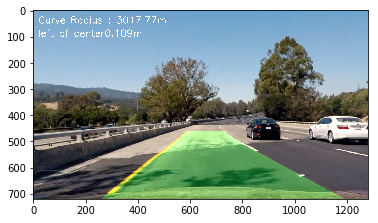

In [21]:
left_fitx = track_left_fit[0]*ploty**2 + track_left_fit[1]*ploty + track_left_fit[2]
right_fitx = track_right_fit[0]*ploty**2 + track_right_fit[1]*ploty + track_right_fit[2]
result = drawing(test_undistort_image, combined_binary, test_warp_image, left_fitx, right_fitx)
text_result = draw_text(result, average_curverad, offset)
plt.figure()
plt.imshow(cv2.cvtColor(text_result, cv2.COLOR_BGR2RGB))

## Process Image

In [22]:
nx = 9 
ny = 6
ret, mtx, dist, rvecs, tvecs = getCameraCalibrationCoefficients('camera_cal/calibration*.jpg', nx, ny)

images num for calibration :  20
Do calibration successfully


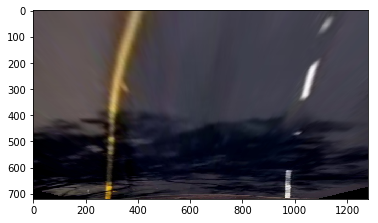

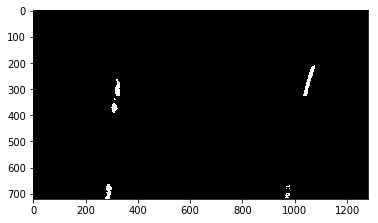

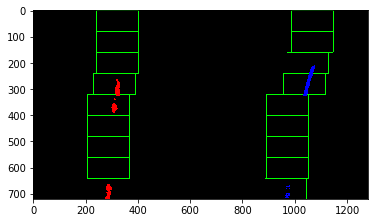

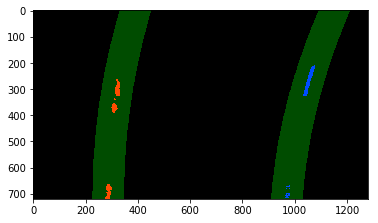

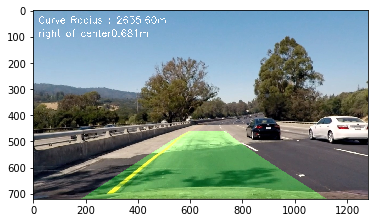

In [35]:
input_image = cv2.imread('original_image/1045.jpg')
src = np.float32([[580, 460], [700, 460], [1096, 720], [200, 720]])
dst = np.float32([[300, 0], [950, 0], [950, 720], [300, 720]])

undistort_image = undistortImage(input_image, mtx, dist)
warp_image, M, Minv = warpImage(undistort_image, src, dst)
plt.figure()
plt.imshow(cv2.cvtColor(warp_image, cv2.COLOR_BGR2RGB))

hlsL_binary = hlsLSelect(warp_image)
labB_binary = labBSelect(warp_image, (205, 255))
combined_binary = np.zeros_like(sx_binary)
combined_binary[(hlsL_binary == 1) | (labB_binary == 0)] = 1
plt.figure()
plt.imshow(combined_binary, cmap='gray')

out_img, left_fit, right_fit, ploty = fit_polynomial(combined_binary, nwindows=9, margin=80, minpix=40)
plt.figure()
plt.imshow(out_img)

track_result, track_left_fit, track_right_fit, ploty,  = search_around_poly(combined_binary, left_fit, right_fit)
plt.figure()
plt.imshow(track_result)

left_curverad, right_curverad, offset = measure_curvature_real(track_left_fit, track_right_fit, ploty)
average_curverad = (left_curverad + right_curverad)/2
left_fitx = track_left_fit[0]*ploty**2 + track_left_fit[1]*ploty + track_left_fit[2]
right_fitx = track_right_fit[0]*ploty**2 + track_right_fit[1]*ploty + track_right_fit[2]
result = drawing(test_undistort_image, combined_binary, test_warp_image, left_fitx, right_fitx)
text_result = draw_text(result, average_curverad, offset)
plt.figure()
plt.imshow(cv2.cvtColor(text_result, cv2.COLOR_BGR2RGB))

## Process Video

In [40]:
nx = 9 
ny = 6
ret, mtx, dist, rvecs, tvecs = getCameraCalibrationCoefficients('camera_cal/calibration*.jpg', nx, ny)

src = np.float32([[580, 460], [700, 460], [1096, 720], [200, 720]])
dst = np.float32([[300, 0], [950, 0], [950, 720], [300, 720]])

video_input = 'project_video.mp4'
video_output = 'output_images/result_video.mp4'

cap = cv2.VideoCapture(video_input)

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(video_output, fourcc, 20.0, (1280, 720))

count = 1
detected = False

while(True):
    ret, image = cap.read()
    if ret:
        undistort_image = undistortImage(image, mtx, dist)
        warp_image, M, Minv = warpImage(undistort_image, src, dst)
        hlsL_binary = hlsLSelect(warp_image)
        labB_binary = labBSelect(warp_image, (205, 255))
        combined_binary = np.zeros_like(sx_binary)
        combined_binary[(hlsL_binary == 1) | (labB_binary == 0)] = 1
        left_fit = []
        right_fit = []
        ploty = []
        if detected == False:
            out_img, left_fit, right_fit, ploty = fit_polynomial(combined_binary, nwindows=9, margin=80, minpix=40)
            if (len(left_fit) > 0 & len(right_fit) > 0) :
                detected = True
            else :
                detected = False
        else:
            track_result, left_fit, right_fit, ploty,  = search_around_poly(combined_binary, left_fit, right_fit)
            if (len(left_fit) > 0 & len(right_fit) > 0) :
                detected = True
            else :
                detected = False
        
        left_curverad, right_curverad, offset = measure_curvature_real(left_fit, right_fit, ploty)
        average_curverad = (left_curverad + right_curverad)/2
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        result = drawing(undistort_image, combined_binary, warp_image, left_fitx, right_fitx)
        text_result = draw_text(result, average_curverad, offset)
        
        out.write(text_result)
        #cv2.imwrite('original_image/' + str(count) + '.jpg', undistort_image)
        #cv2.imwrite('result_image/' + str(count) + '.jpg', text_result)
        count += 1
    else:
        break
        
cap.release()
out.release()

images num for calibration :  20
Do calibration successfully
